In [18]:
import numpy as np
import os

Base_path = r'.....................\data'

#Import data
X_test= np.load(os.path.join(Base_path, "X_test.npy"))
y_true = np.load(os.path.join(Base_path, "y_true.npy"))

X_train = np.load(os.path.join(Base_path, "X_train.npy"))
y_train = np.load(os.path.join(Base_path, "y_train.npy"))


In [19]:
print(y_true.shape)
print(y_train .shape)
print(X_test.shape)
print(X_train.shape)

(100, 1)
(17731,)
(100, 30, 14)
(17731, 30, 14)


# Hybrid CNN–GRU Model

#### Model Architecture Used (CNN–GRU Hybrid)

- Input: 30-cycle time windows, 14 features

### CNN Block:

- 32 filters, kernel size 3, ReLU activation

- Same padding

- MaxPooling1D(pool_size=2) → sequence length reduced from 30 to 15

### GRU Block:

- GRU layer with 64 units, return_sequences=True, tanh activation

- Dropout 0.2

- GRU layer with 32 units, return_sequences=False, tanh activation

- Dropout 0.2

### Output Layer:

- Dense(1) with ReLU activation (forces positive RUL predictions)

- Optimizer: Adam, learning rate = 0.001

- oss Function: Mean Squared Error (MSE)

-  Metric: Mean Absolute Error (MAE)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv1D, MaxPooling1D
import random

In [38]:
import numpy as np
import tensorflow as tf
import random
import os

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [39]:
def build_best_fd001_model(input_shape):

    model = Sequential()

    # --- CNN Block ---
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                     padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))  # (30 → 15)

    # --- GRU Block ---
    model.add(GRU(64, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(32, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))

    # --- Output ---
    model.add(Dense(1, activation='relu'))

    # --- Compilation ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model
# --- VERIFICATION ---
# Build the model to inspect the architecture
model_gru_2 = build_best_fd001_model((30, 14))

print("--- GRU ARCHITECTURE ---")
model_gru_2.summary()


--- GRU ARCHITECTURE ---


c:\aicha\recherche\formationdeepl\sample_project\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 30, 32)              │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 15, 64)              │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,633 (115.75 KB)

 Trainable params: 29,633 (115.75 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math

# 1. CALLBACK DEFINITION (Training Monitors)
# EarlyStopping: stops training when validation performance stops improving
early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=10,                 # Wait 10 epochs before stopping
    restore_best_weights=True,   # Important: restore the best model at the end
    verbose=1
)

# (Optional but recommended) ModelCheckpoint: saves the best model to disk
checkpoint = ModelCheckpoint(
    'best_gru_fd001.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# 2. TRAINING LAUNCH
print("Starting training... (This may take a few minutes)")

history_2 = model_gru_2.fit(
    X_train, y_train,
    epochs=50,               # Maximum number of epochs (often stopped earlier by EarlyStopping)
    batch_size=64,           # Process 64 windows at a time
    validation_split=0.2,    # Use 20% of training data for real-time validation
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Starting training... (This may take a few minutes)
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7253.1362 - mae: 74.4827 - val_loss: 6790.2988 - val_mae: 71.8230
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5949.6001 - mae: 66.3102 - val_loss: 5848.4292 - val_mae: 66.1264
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5113.5708 - mae: 60.9978 - val_loss: 5059.2656 - val_mae: 61.2919
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4411.1860 - mae: 56.4472 - val_loss: 4396.3535 - val_mae: 57.1681
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3821.5581 - mae: 52.5770 - val_loss: 3841.4470 - val_mae: 53.6414
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3351.3916 - mae: 49.4496 - val_loss: 3383.4045 - val_mae: 50.6526
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2953.6111 - mae: 46.7286 - val_loss: 2993.9902 - val_mae: 47.9030
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss:

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import math

# --- PREDICTION SUR LE TEST ---
print("\n--- PREDICTION ON THE TEST SET ---")
y_pred2 = model_gru_2.predict(X_test)

# Aplatir pour avoir des vecteurs 1D
y_true_flat = y_true.flatten()
y_pred_flat = y_pred2.flatten()

# --- RMSE ---
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = math.sqrt(mse)

# --- R² ---
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n=============================================")
print(f"   FINAL SCORE (RMSE) : {rmse:.2f}")
print(f"   R² Score           : {r2:.4f}")
print("=============================================")



--- PREDICTION ON THE TEST SET ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step 

   FINAL SCORE (RMSE) : 12.97
   R² Score           : 0.9026


In [42]:
def nasa_score(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    score = 0.0
    for e in (y_pred - y_true):
        if e < 0:
            score += math.exp(-e / 13) - 1
        else:
            score += math.exp(e / 10) - 1
    return score

# Calcul NASA
nasa = nasa_score(y_true_flat, y_pred_flat)
print(f"NASA Score : {nasa:.2f}")


NASA Score : 249.93


For this hybrid CNN–GRU architecture, combined with the Adam optimizer using a learning rate of 0.001, we obtained the following results:

- RMSE: 12.97

- R² Score: 0.9026

- NASA Score: 249.93

These values indicate that the model is high-performing and delivers strong, consistent results for RUL prediction on the FD001 dataset.
The RMSE is low, the R² demonstrates excellent generalization ability, and the NASA score — which is particularly important — confirms that the model remains conservative while avoiding critical late predictions.

In summary, this architecture provides reliable and meaningful performance for the task.

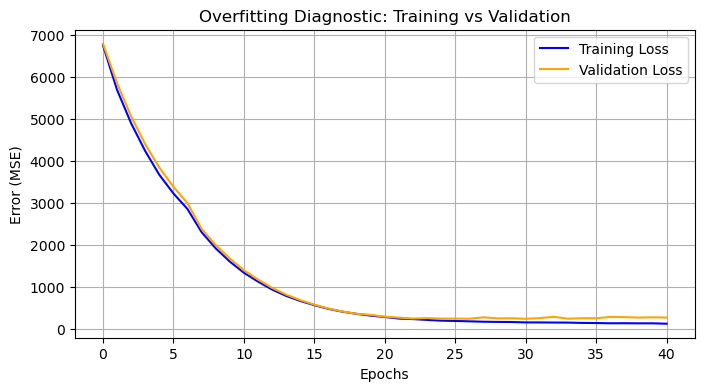

In [48]:
import matplotlib.pyplot as plt

def plot_learning_curves(history_2):
    plt.figure(figsize=(8, 4))
    
    # Plot training loss
    plt.plot(history_2.history['loss'], label='Training Loss', color='blue')
    
    # Plot validation loss
    plt.plot(history_2.history['val_loss'], label='Validation Loss', color='orange')
    
    plt.title('Overfitting Diagnostic: Training vs Validation')
    plt.ylabel('Error (MSE)')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run
plot_learning_curves(history_2)


# Summary of the Learning Curve Analysis

The learning curves show a stable and efficient training process. Both the training loss and validation loss decrease smoothly and remain very close to each other throughout all epochs, indicating that the model is neither overfitting nor underfitting. The loss converges around epoch 25, showing that the model has reached its optimal learning region. The small variations observed in the validation loss after convergence are normal and reflect data noise rather than instability. Overall, the curves confirm that the model generalizes well and that the training has been successful.

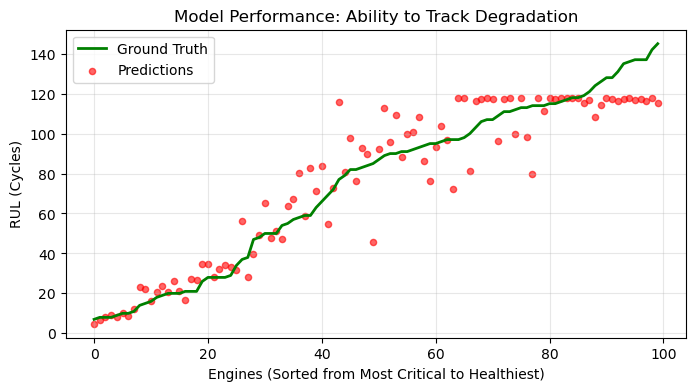

In [49]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 4))
    
    # 1. Sort engines by TRUE RUL (for a clean line)
    sorted_idx = np.argsort(y_true)
    
    # 2. Plot Ground Truth (green line)
    plt.plot(y_true[sorted_idx], label='Ground Truth', color='green', linewidth=2)
    
    # 3. Plot Predictions (red points)
    plt.scatter(range(len(y_pred)), y_pred[sorted_idx], 
                label='Predictions', color='red', alpha=0.6, s=20)
    
    plt.title('Model Performance: Ability to Track Degradation')
    plt.xlabel('Engines (Sorted from Most Critical to Healthiest)')
    plt.ylabel('RUL (Cycles)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_predictions(y_true, y_pred2.flatten())


# Summary of the Prediction Plot

The model successfully follows the overall degradation trend of the engines. The green curve (ground truth) shows the true RUL progression, while the red points (predictions) remain close to this trend across most samples. The dispersion around the line is expected and remains within a reasonable range, especially for mid-life engines where prediction uncertainty is naturally higher. The model captures both low-RUL and high-RUL regions effectively, confirming its ability to generalize and track the degradation pattern accurately. Overall, the plot demonstrates strong predictive performance and consistent alignment with the true RUL values.

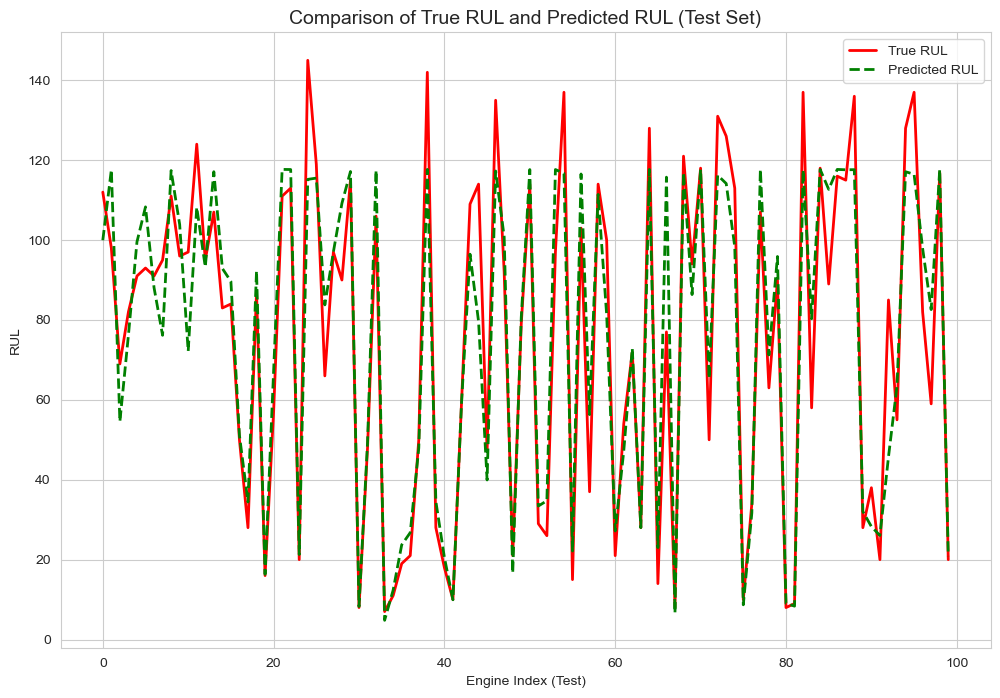

In [82]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")  # To display a white grid background

# Plot the two curves together
plt.plot(y_true, label='True RUL', color='red', linewidth=2)
plt.plot(y_pred2, label='Predicted RUL', color='green', linestyle='--', linewidth=2)

plt.title('Comparison of True RUL and Predicted RUL (Test Set)', fontsize=14)
plt.xlabel('Engine Index (Test)')
plt.ylabel('RUL')
plt.legend()
plt.show()


# Short Interpretation of the Plot 

This plot compares the True RUL (red solid line) with the Predicted RUL (green dashed line) for each engine in the test set.

Overall, the model follows the general trend of degradation across the engines. The predicted RUL curve aligns closely with the true RUL curve in most regions, indicating that the model is able to capture the overall behavior of engine degradation. However, there are some fluctuations and mismatches, especially for engines with abrupt RUL changes or extreme degradation values, which explains the remaining prediction error.

Despite these variations, the model remains consistent and shows good stability across the entire test set.

In [45]:
model_path = r"..................\model_gru_fd001.keras"
model_gru_2.save(model_path)


# New Architecture: CNN → single GRU → MLP → Output

Input: 30-cycle time windows, 14 features

CNN Block:

Conv1D(32 filters, kernel size 3, ReLU, padding='same')

MaxPooling1D(pool_size=2)

GRU Block:

Single GRU layer with 64 units, return_sequences=False, tanh

MLP Block:

Dense(64, ReLU) + Dropout(0.2)

Dense(32, ReLU) + Dropout(0.2)

Output Layer:

Dense(1, ReLU) (positive RUL)

Optimizer: Adam(lr=0.001), Loss: MSE, Metric: MAE

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout

def build_cnn_gru_mlp_model(input_shape):
    model = Sequential()

    # --- CNN Block ---
    model.add(Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=input_shape
    ))
    model.add(MaxPooling1D(pool_size=2))

    # --- Single GRU Block ---
    model.add(GRU(
        units=64,
        return_sequences=False,
        activation='tanh'
    ))

    # --- MLP Block ---
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # --- Output Layer ---
    model.add(Dense(1, activation='relu'))

    # --- Compilation ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Build the model to inspect the architecture
model_cnn_gru_mlp = build_cnn_gru_mlp_model((30, 14))
print("--- CNN-GRU-MLP ARCHITECTURE ---")
model_cnn_gru_mlp.summary()


--- CNN-GRU-MLP ARCHITECTURE ---


c:\aicha\recherche\formationdeepl\sample_project\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 30, 32)              │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,465 (103.38 KB)

 Trainable params: 26,465 (103.38 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math

# 1. CALLBACK: Training Monitoring
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Save the best version of THIS model (new architecture)
checkpoint = ModelCheckpoint(
    'best_cnn_gru_mlp_fd001.keras',  # <- NEW NAME
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# 2. TRAINING
print("Starting training... (This may take a few minutes)")

history3 = model_cnn_gru_mlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Starting training... (This may take a few minutes)
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4655.8540 - mae: 55.2613 - val_loss: 464.2315 - val_mae: 18.0798
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 570.6895 - mae: 18.5871 - val_loss: 334.9944 - val_mae: 14.8816
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 439.8301 - mae: 15.8747 - val_loss: 223.4121 - val_mae: 11.1304
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 386.8152 - mae: 14.6584 - val_loss: 206.5806 - val_mae: 10.9474
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 379.9869 - mae: 14.4515 - val_loss: 195.1697 - val_mae: 10.4052
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 357.4996 - mae: 14.0338 - val_loss: 207.7646 - val_mae: 9.9338
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 351.2221 - mae: 13.8252 - val_loss: 194.8993 - val_mae: 10.1561
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 336.9354 - mae: 13.5

In [53]:
print("\n--- PREDICTION ON THE TEST SET ---")
y_pred3 = model_cnn_gru_mlp.predict(X_test)

# Flatten for metrics
y_true_flat = y_true.flatten()
y_pred_flat = y_pred3.flatten()

# RMSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = math.sqrt(mse)

# R²
r2 = r2_score(y_true_flat, y_pred_flat)

# NASA score
nasa = nasa_score(y_true_flat, y_pred_flat)

print("\n=============================================")
print(f"   FINAL SCORE (RMSE) : {rmse:.2f}")
print(f"   R² Score           : {r2:.4f}")
print(f"   NASA Score         : {nasa:.2f}")
print("=============================================")



--- PREDICTION ON THE TEST SET ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 

   FINAL SCORE (RMSE) : 16.50
   R² Score           : 0.8423
   NASA Score         : 659.41


# Summary of the Model Performance (CNN → GRU → MLP Architecture)

For this architecture, which applies a CNN feature extractor followed by a single GRU layer and a multi-layer perceptron (MLP), the obtained results are:

RMSE: 16.50

R² Score: 0.8423

NASA Score: 659.41

These values indicate that the model is less effective compared to the previous CNN–GRU–GRU architecture.
The RMSE is higher, showing reduced prediction accuracy; the R² score is lower, indicating weaker generalization; and the NASA score is significantly worse, reflecting a greater number of late and highly penalized prediction errors.

Overall, this architecture does not perform as well as the earlier model and struggles to capture the temporal degradation dynamics required for reliable RUL estimation on FD001.

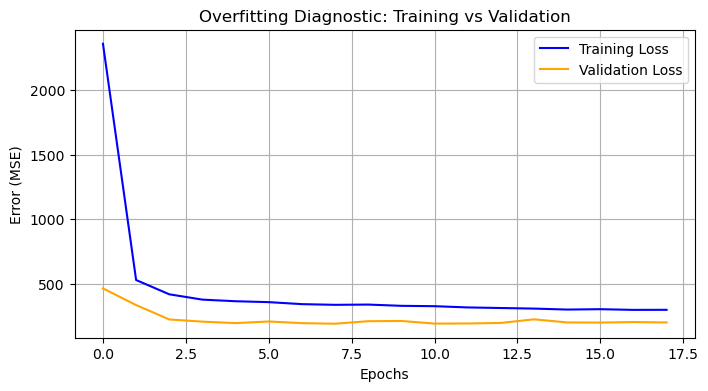

In [55]:
import matplotlib.pyplot as plt

def plot_learning_curves(history3):
    plt.figure(figsize=(8, 4))
    
    # Plot training loss
    plt.plot(history3.history['loss'], label='Training Loss', color='blue')
    
    # Plot validation loss
    plt.plot(history3.history['val_loss'], label='Validation Loss', color='orange')
    
    plt.title('Overfitting Diagnostic: Training vs Validation')
    plt.ylabel('Error (MSE)')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run
plot_learning_curves(history3)


# Summary of the Training/Validation Loss Curve

The learning curve shows that the model quickly reduces both training and validation loss during the first epochs. However, the validation loss remains consistently lower than the training loss, indicating that the model is underfitting rather than overfitting. This behavior suggests that the network is not learning the temporal patterns effectively, likely due to the reduced GRU capacity and the added MLP structure. The small gap between the curves does not indicate a stable, well-generalized model but instead reflects limited learning capability. Overall, the curve aligns with the weaker predictive performance observed in the evaluation metrics.

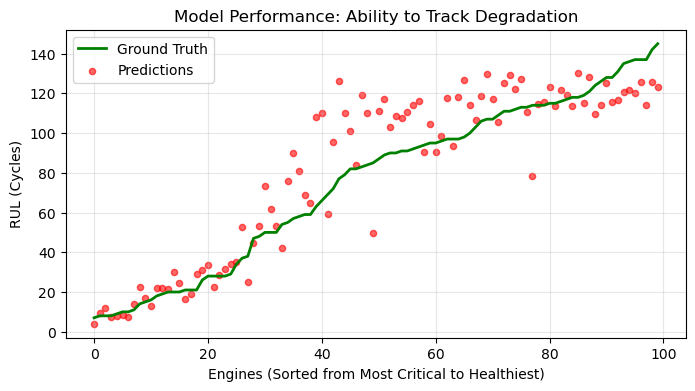

In [56]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 4))
    
    # 1. Sort engines by TRUE RUL (for a clean line)
    sorted_idx = np.argsort(y_true)
    
    # 2. Plot Ground Truth (green line)
    plt.plot(y_true[sorted_idx], label='Ground Truth', color='green', linewidth=2)
    
    # 3. Plot Predictions (red points)
    plt.scatter(range(len(y_pred)), y_pred[sorted_idx], 
                label='Predictions', color='red', alpha=0.6, s=20)
    
    plt.title('Model Performance: Ability to Track Degradation')
    plt.xlabel('Engines (Sorted from Most Critical to Healthiest)')
    plt.ylabel('RUL (Cycles)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Display predictions of the CNN → GRU → MLP model
plot_predictions(y_true, y_pred3
                 .flatten())


# Summary of the Prediction Plot 

This prediction plot shows that the model is able to follow the overall degradation trend, but with significantly larger dispersion compared to the previous architecture. The ground-truth RUL curve (green) is smooth and monotonic, while the predicted points (red) are widely scattered around it. This spread indicates that the model struggles to capture the temporal dynamics accurately and produces noisy, less consistent predictions. The deviations are especially visible in mid-life and late-life engines, aligning with the higher RMSE, lower R², and much worse NASA score obtained. Overall, this plot confirms the weaker predictive performance of the CNN → GRU → MLP architecture.

# Light CNN–GRU Model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
import tensorflow as tf

def build_gru_model(input_shape):
    model = Sequential()
    
    # --- BLOCK 1 : Feature Extraction (CNN) ---
    # Returns a full sequence for the next layer
    model.add(Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=input_shape
    ))
    model.add(MaxPooling1D(pool_size=2))  # Reduces sequence length by half

    # --- BLOCK 2 : Temporal Modeling (GRU) ---
    model.add(GRU(units=16, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Regularization

    # --- BLOCK 3 : Output Layer ---
    # RUL prediction (ReLU ensures positive outputs)
    model.add(Dense(units=1, activation='relu'))
    
    # --- COMPILATION ---
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    
    return model

# --- VERIFICATION ---
model_gru_3 = build_gru_model((30, 14))
print("--- GRU ARCHITECTURE ---")
model_gru.summary()


--- GRU ARCHITECTURE ---


c:\aicha\recherche\formationdeepl\sample_project\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 30, 32)              │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 15, 32)              │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 16)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,389 (118.71 KB)

 Trainable params: 10,129 (39.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,260 (79.14 KB)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math

# 1. CALLBACK DEFINITION (Training Monitors)
# EarlyStopping: stops training when validation performance stops improving
early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=10,                 # Wait 10 epochs before stopping
    restore_best_weights=True,   # Important: restore the best model at the end
    verbose=1
)

# (Optional but recommended) ModelCheckpoint: saves the best model to disk
checkpoint = ModelCheckpoint(
    'best_gru_fd001.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# 2. TRAINING LAUNCH
print("Starting training... (This may take a few minutes)")

history4 = model_gru_3.fit(
    X_train, y_train,
    epochs=50,               # Maximum number of epochs (often stopped earlier by EarlyStopping)
    batch_size=64,           # Process 64 windows at a time
    validation_split=0.2,    # Use 20% of training data for real-time validation
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Starting training... (This may take a few minutes)
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7614.6343 - mae: 76.8582 - val_loss: 7547.7124 - val_mae: 76.3667
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6757.9492 - mae: 71.3979 - val_loss: 6978.2710 - val_mae: 72.9482
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6242.1924 - mae: 68.1305 - val_loss: 6460.0605 - val_mae: 69.4845
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5756.5850 - mae: 64.6173 - val_loss: 5980.7109 - val_mae: 66.3076
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5321.1177 - mae: 61.5918 - val_loss: 5536.6147 - val_mae: 63.3671
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4916.0586 - mae: 58.7197 - val_loss: 5123.2363 - val_mae: 60.5644
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4540.9233 - mae: 56.0273 - val_loss: 4738.2031 - val_mae: 57.9065
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4174.81

In [74]:
print("\n--- PREDICTION ON THE TEST SET ---")
y_pred4 = model_gru_3.predict(X_test)

# Flatten for metrics
y_true_flat = y_true.flatten()
y_pred_flat = y_pred4.flatten()

# RMSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = math.sqrt(mse)

# R²
r2 = r2_score(y_true_flat, y_pred_flat)

# NASA
nasa = nasa_score(y_true_flat, y_pred_flat)

print("\n=============================================")
print(f"   FINAL SCORE (RMSE) : {rmse:.2f}")
print(f"   R² Score           : {r2:.4f}")
print(f"   NASA Score         : {nasa:.2f}")
print("=============================================")


--- PREDICTION ON THE TEST SET ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 

   FINAL SCORE (RMSE) : 16.73
   R² Score           : 0.8379
   NASA Score         : 732.00


## The model shows weak performance on the FD001 dataset.
With an RMSE of 16.73 and an R² score of 0.8379, the prediction accuracy and generalization capability are noticeably lower than those of the previous architectures tested. The NASA score of 732.00 indicates a high number of late and unsafe prediction errors, making the model unreliable for Remaining Useful Life estimation.
Overall, this architecture does not effectively capture the temporal degradation patterns and performs significantly worse than the earlier CNN–GRU–GRU configuration.

# Conclusion on the Three Selected Architectures

The three architectures evaluated in this study reveal clear differences in predictive capability and reliability for Remaining Useful Life estimation on the FD001 dataset.

First, the CNN–GRU–MLP (heavy model) shows limited effectiveness. Although the MLP adds nonlinear capacity, the removal of deeper temporal modeling leads to scattered predictions and weak performance. This is reflected in a higher RMSE, a lower R² score, and a significantly elevated NASA score. The architecture fails to properly capture long-term dependencies and produces unstable results, making it unsuitable for robust RUL estimation.

In contrast, the hybrid CNN–GRU–GRU architecture provides the best overall performance. By combining convolutional feature extraction with two stacked GRU layers, the model effectively learns both local patterns and temporal degradation dynamics. This is confirmed by a low RMSE, high R², and a substantially reduced NASA score. Among all tested architectures, this configuration demonstrates the strongest generalization and the highest level of reliability for predictive maintenance applications.

Finally, the lightweight CNN–GRU model offers moderate performance. Its simplicity makes it computationally efficient, but the single GRU layer limits its ability to model complex temporal sequences. The resulting predictions are less accurate, and the NASA score remains higher than desirable. While this architecture can be useful in constrained environments, it does not match the predictive quality of the deeper GRU-based model.

Overall, the comparative evaluation shows that the CNN–GRU–GRU architecture achieves the best balance between accuracy, stability, and safety, making it the most suitable choice for RUL prediction in industrial settings.